In [1]:
import numpy as np, GPy, pandas as pd
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# Example Workflow

In this notebook we will look at an example workflow of running topslam on a dataset Y. In order to show the expected behaviours and outcomes, we will use a simulated differentiation pattern. The simulation is included in the package and can be accessed as follows:

In [2]:
from topslam.simulation import qpcr_simulation

In [3]:
seed_differentiation = 5001
seed_gene_expression = 0

In [4]:
Xsim, simulate_new, t, c, labels, seed = qpcr_simulation(seed=seed_differentiation)

In [5]:
np.random.seed(seed_gene_expression)
Y = simulate_new()

## Dimensionality reduction initialization

In order to fit the Baysian GPLVM, we will use five other dimensionality reduction techniques as initialization. This means, we present the BaysianGPLVM with the solutions generated from these techniques as a **starting point**. BayesianGPLVM will then proceed from there and find the most likeliy fit and reduced space dimensionality. (See ARD parameters later)

In [6]:
from sklearn.manifold import TSNE, LocallyLinearEmbedding, SpectralEmbedding, Isomap
from sklearn.decomposition import FastICA, PCA

methods = {'t-SNE':TSNE(n_components=2),
           'PCA':PCA(n_components=2), 
           'Spectral': SpectralEmbedding(n_components=2, n_neighbors=10), 
           'Isomap': Isomap(n_components=2, n_neighbors=10), 
           'ICA': FastICA(n_components=2)
           }

In [7]:
from topslam.optimization import run_methods

X_init, dims = run_methods(Y, methods)

## BayesianGPLVM

We run BayesianGPLVM using the optimization routines given in the optimization package of topslam. You can run the BayesianGPLVM yourself for more control (see for example https://github.com/SheffieldML/notebook/blob/master/compbio/SingleCellDataWithGPy.ipynb). We do not expect any linear relation in the data and will therefore not model a linear dimenion:

In [8]:
from topslam.optimization import create_model, optimize_model
m = create_model(Y, X_init, linear_dims=0)

In [9]:
m.optimize(messages=1, max_iters=5e3)

### ARD: Discovery of significant dimensions

We can assign the number of dimensions to be used in the reduced space by the ARD parameters of the kernel. 

Most significant input dimensions: (8, 6)


 /Users/maxz/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


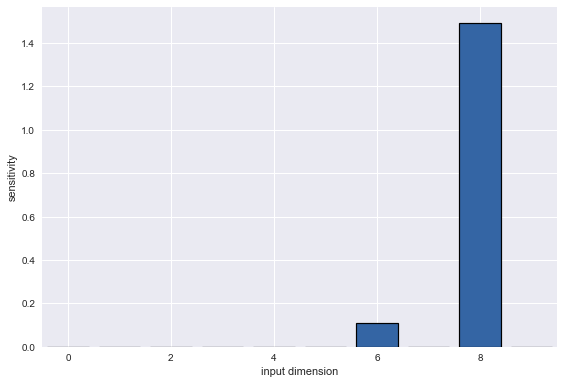

In [10]:
m.kern.plot_ARD()
print("Most significant input dimensions: {}".format(m.kern.get_most_significant_input_dimensions()[:2]))

### Lower Dimensional Representation

So now we know which dimensions are important and we can look at those, by plotting them using the labels generated by the simulation:

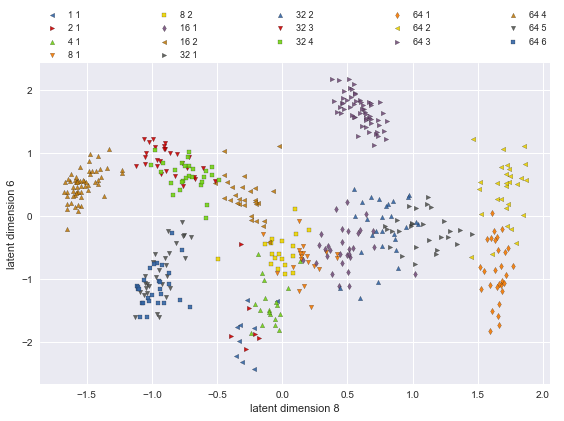

In [11]:
m.plot_scatter(labels=labels)

## Landscape extraction

Everything before this stage was initialization and running of the model. We can now use the learnt model to extract the probabilistic landscape from this model, and plot the extracted timeline. We will also compare it to the other dimensionality reduction techniques and their extracted timelines (for ICA and t-SNE). 

In [12]:
from topslam import ManifoldCorrectionTree
m_topslam = ManifoldCorrectionTree(m)

We can plot the extracted landscape and a graph representing the minimal spanning tree along which we extract the time. We simulated the time for the samples in order, so the start for the extracted time is 0. The startin cell plays a crucial role in the extraction of the timeline and should always be supplied.

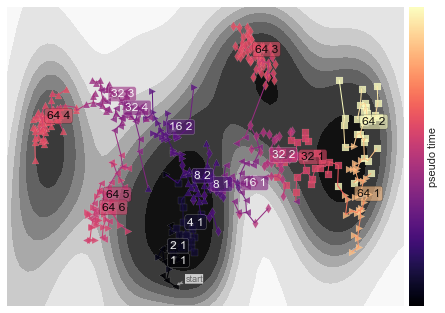

In [13]:
ax = m_topslam.plot_waddington_landscape()
m_topslam.plot_time_graph(labels=labels, start=0, ax=ax)

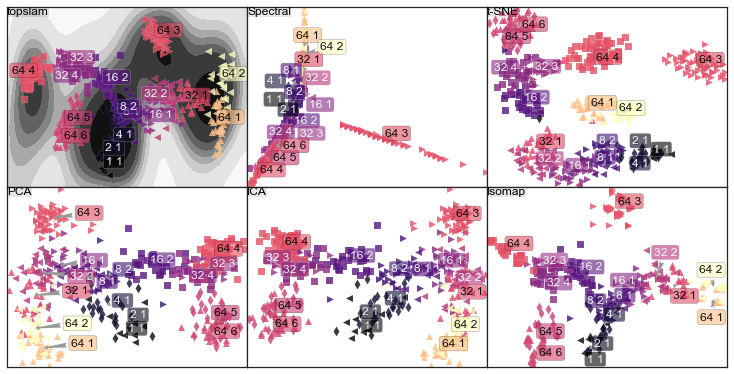

In [14]:
from topslam.plotting import plot_comparison
with sns.axes_style('white'):
    ax = plot_comparison(m_topslam, X_init, dims, labels, np.unique(labels), 0)

# Pseudotime

We can now extract the pseudotime and compare it to simulated times. We will compare topslam to ICA and t-SNE extracted landscapes using pearson correlation between extracted and simulated times:

In [15]:
from scipy.stats import linregress
from scipy.spatial.distance import pdist, squareform
from topslam.simulation.graph_extraction import extract_manifold_distances_mst

In [16]:
pt_topslam = m_topslam.get_pseudo_time(start=0)
D_ica, mst_ica = extract_manifold_distances_mst(squareform(pdist(X_init[:, dims['ICA']])))
pt_ica = D_ica[0] # only take the distances from the start (which is 0 in this case)
D_tsne, mst_tsne = extract_manifold_distances_mst(squareform(pdist(X_init[:, dims['t-SNE']])))
pt_tsne = D_tsne[0] # only take the distances from the start (which is 0 in this case)

In [17]:
result_df = pd.DataFrame(columns=['slope', 'intercept', 'r_value', 'p_value', 'std_err'])
result_df.loc['topslam'] = linregress(pt_topslam, t.flat)[:]
result_df.loc['ICA'] = linregress(pt_ica, t.flat)[:]
result_df.loc['t-SNE'] = linregress(pt_tsne, t.flat)

In [18]:
result_df

,slope,intercept,r_value,p_value,std_err
topslam,1.770540,1.440269,0.906825,7.783746e-179,0.037921
ICA,0.233922,1.403282,0.799686,2.059462e-106,0.008093
t-SNE,0.081059,2.022688,0.604221,2.099797e-48,0.004926


In [19]:
time_df = pd.DataFrame(t, columns=['simulated'])
time_df['topslam'] = pt_topslam
time_df['ICA'] = pt_ica
time_df['t-SNE'] = pt_tsne

 /home/maxz/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning:axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.


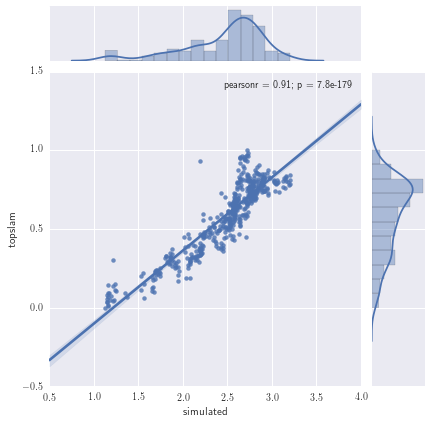

In [20]:
sns.jointplot('simulated', 'topslam', data=time_df, kind='reg')

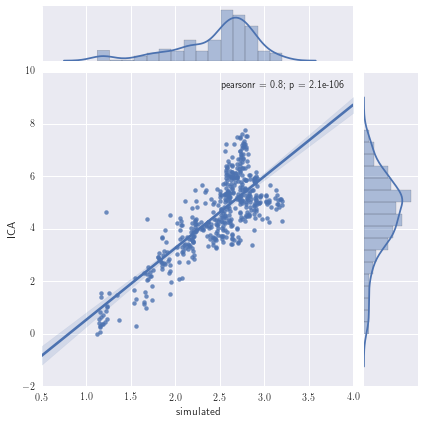

In [21]:
sns.jointplot('simulated', 'ICA', data=time_df, kind='reg')

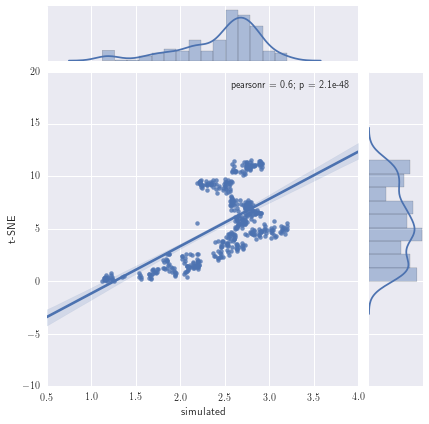

In [22]:
sns.jointplot('simulated', 't-SNE', data=time_df, kind='reg')